<a href="https://colab.research.google.com/github/hanieas/Chrome-extension/blob/master/TabTransformer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 39.9 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os

In [ ]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

In [ ]:
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [ ]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace('.','')
)

<ipython-input-10-d19156d9c625>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.income_bracket = test_data.income_bracket.apply(


In [ ]:
folder_name = 'census_income'
if not os.path.isdir(folder_name):
  os.mkdir(folder_name)

train_data_file = folder_name + '/train_data.csv'
test_data_file = folder_name + '/test_data.csv'

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]

# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}

# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
] # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [ ]:
target_label_lookup = layers.StringLookup(
    vocabulary = TARGET_LABELS, mask_token = None, num_oov_indices=0
)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
def prepare_example(features, target):
  target_index = target_label_lookup(target)
  weights = features.pop(WEIGHT_COLUMN_NAME)
  return features, target_index, weights

def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

In [ ]:
def run_experiment(model,train_data_file,test_data_file,num_epochs,learning_rate, weight_decay, batch_size):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Total model weights: 109629


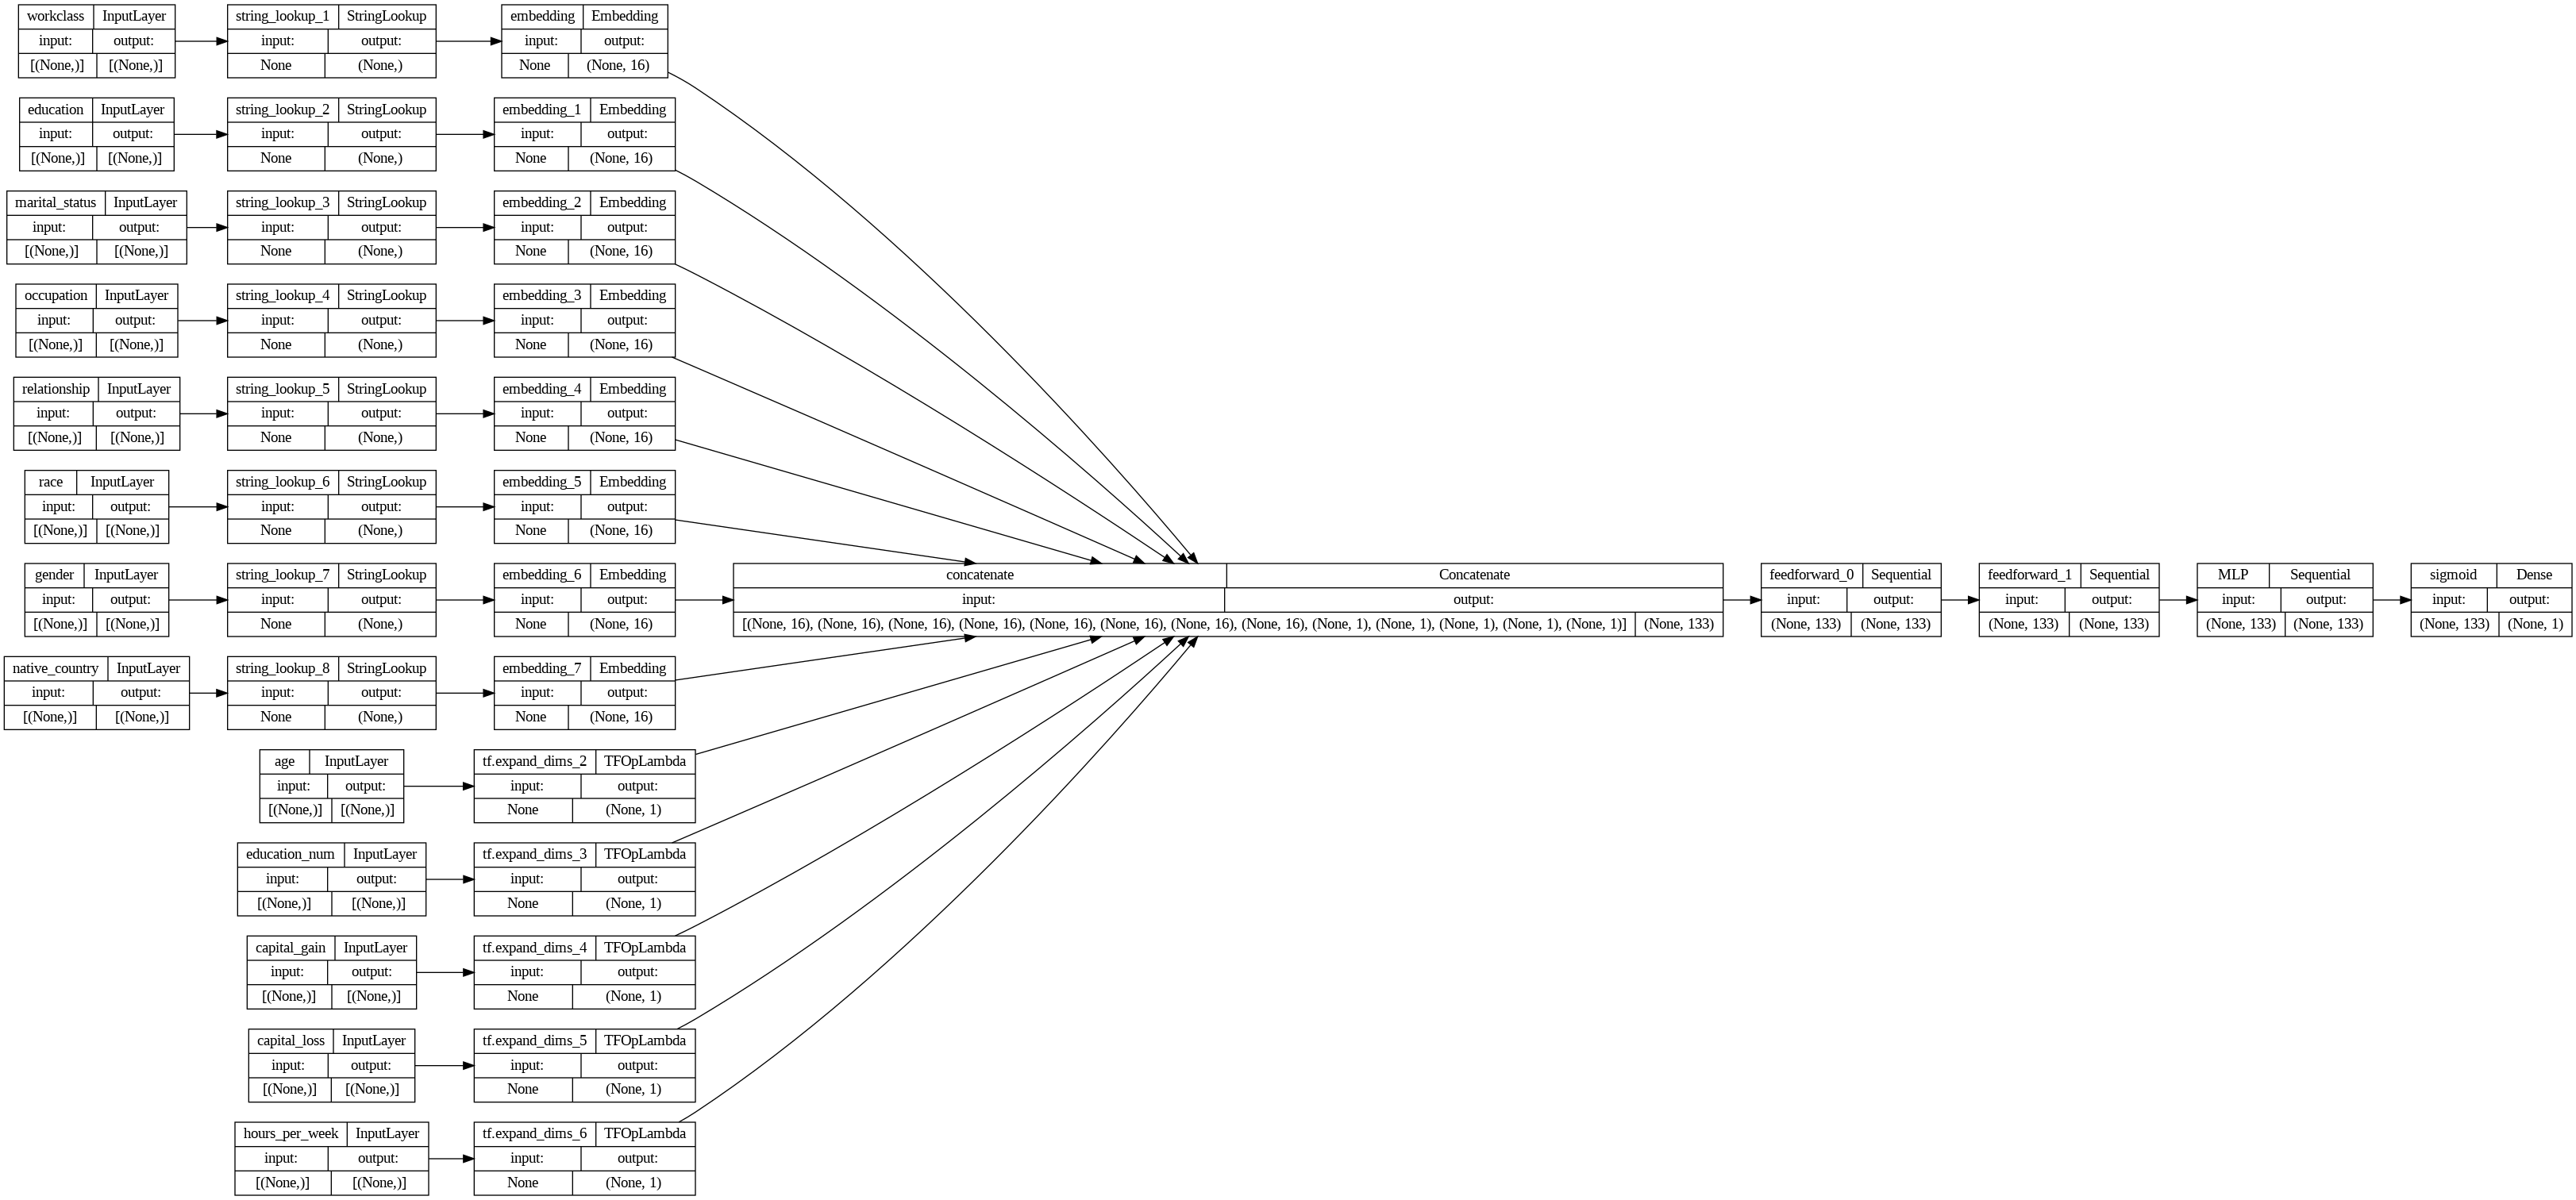

In [ ]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [ ]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    121/Unknown - 7s 14ms/step - loss: 110380.5781 - accuracy: 0.7429

123/123 [==============================] - 8s 21ms/step - loss: 110125.4219 - accuracy: 0.7436 - val_loss: 102926.1172 - val_accuracy: 0.7812
Epoch 2/15
121/123 [============================>.] - ETA: 0s - loss: 89166.1719 - accuracy: 0.7722

123/123 [==============================] - 2s 13ms/step - loss: 88947.2500 - accuracy: 0.7728 - val_loss: 69370.3281 - val_accuracy: 0.8134
Epoch 3/15
119/123 [============================>.] - ETA: 0s - loss: 75022.6953 - accuracy: 0.7965

123/123 [==============================] - 2s 13ms/step - loss: 74861.1484 - accuracy: 0.7972 - val_loss: 68759.3516 - val_accuracy: 0.8186
Epoch 4/15
122/123 [============================>.] - ETA: 0s - loss: 72237.0938 - accuracy: 0.8039

123/123 [==============================] - 2s 14ms/step - loss: 72248.1953 - accuracy: 0.8039 - val_loss: 67628.3047 - val_accuracy: 0.8214
Epoch 5/15
120/123 [============================>.] - ETA: 0s - loss: 70252.1484 - accuracy: 0.8046

123/123 [==============================] - 2s 13ms/step - loss: 70207.0781 - accuracy: 0.8051 - val_loss: 66066.2578 - val_accuracy: 0.8179
Epoch 6/15
121/123 [============================>.] - ETA: 0s - loss: 68965.5078 - accuracy: 0.8096

123/123 [==============================] - 3s 20ms/step - loss: 68928.6953 - accuracy: 0.8097 - val_loss: 67655.6641 - val_accuracy: 0.8217
Epoch 7/15
123/123 [==============================] - ETA: 0s - loss: 68640.2031 - accuracy: 0.8103

123/123 [==============================] - 2s 13ms/step - loss: 68640.2031 - accuracy: 0.8103 - val_loss: 66692.5781 - val_accuracy: 0.8229
Epoch 8/15
121/123 [============================>.] - ETA: 0s - loss: 68035.2500 - accuracy: 0.8130

123/123 [==============================] - 2s 13ms/step - loss: 67947.4375 - accuracy: 0.8133 - val_loss: 65728.9609 - val_accuracy: 0.8201
Epoch 9/15
120/123 [============================>.] - ETA: 0s - loss: 67581.6641 - accuracy: 0.8153

123/123 [==============================] - 2s 14ms/step - loss: 67480.2656 - accuracy: 0.8155 - val_loss: 65308.4805 - val_accuracy: 0.8172
Epoch 10/15
120/123 [============================>.] - ETA: 0s - loss: 67251.6875 - accuracy: 0.8140

123/123 [==============================] - 2s 13ms/step - loss: 67149.0781 - accuracy: 0.8141 - val_loss: 66220.5078 - val_accuracy: 0.8220
Epoch 11/15
119/123 [============================>.] - ETA: 0s - loss: 66112.4375 - accuracy: 0.8204

123/123 [==============================] - 2s 14ms/step - loss: 65999.4531 - accuracy: 0.8206 - val_loss: 68003.3594 - val_accuracy: 0.8227
Epoch 12/15
122/123 [============================>.] - ETA: 0s - loss: 64580.2969 - accuracy: 0.8276

123/123 [==============================] - 2s 16ms/step - loss: 64571.9062 - accuracy: 0.8275 - val_loss: 64787.2227 - val_accuracy: 0.8337
Epoch 13/15
118/123 [===========================>..] - ETA: 0s - loss: 63263.8398 - accuracy: 0.8319

123/123 [==============================] - 2s 15ms/step - loss: 63085.9219 - accuracy: 0.8320 - val_loss: 65871.6797 - val_accuracy: 0.8373
Epoch 14/15
120/123 [============================>.] - ETA: 0s - loss: 62735.9766 - accuracy: 0.8323

123/123 [==============================] - 2s 13ms/step - loss: 62662.6836 - accuracy: 0.8323 - val_loss: 63273.1953 - val_accuracy: 0.8350
Epoch 15/15
120/123 [============================>.] - ETA: 0s - loss: 62587.2227 - accuracy: 0.8335

123/123 [==============================] - 2s 16ms/step - loss: 62548.6406 - accuracy: 0.8333 - val_loss: 63272.4492 - val_accuracy: 0.8371


Model training finished
Validation accuracy: 83.71%


Total model weights: 87479


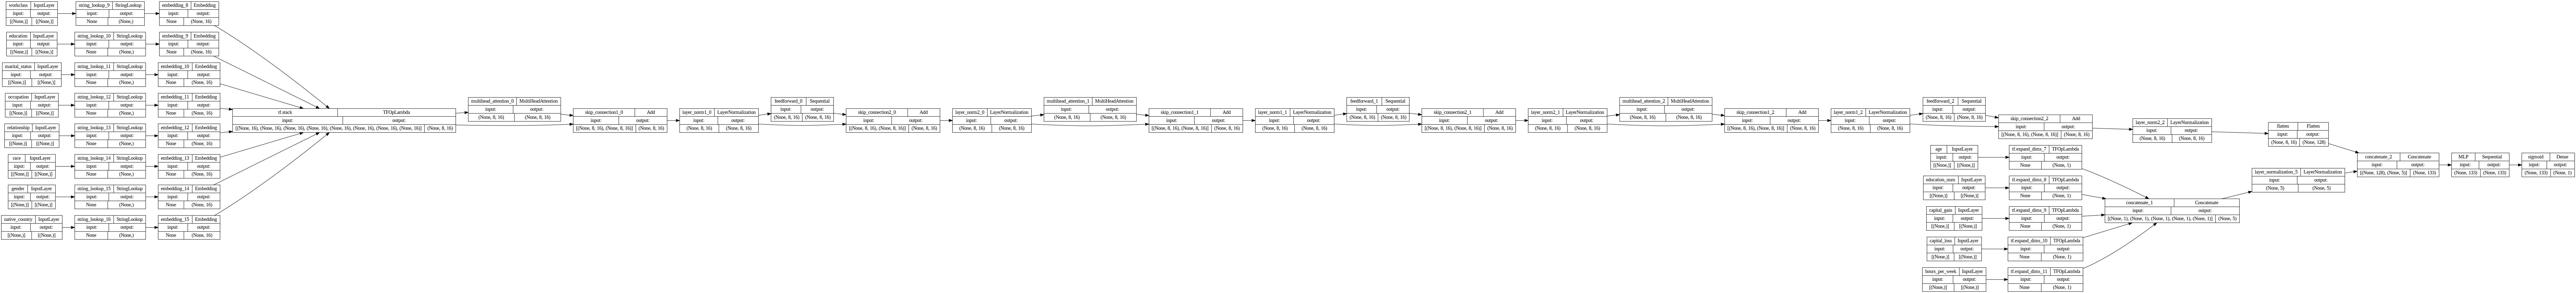

In [ ]:

def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [ ]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/15
    122/Unknown - 11s 31ms/step - loss: 79974.8047 - accuracy: 0.8005

123/123 [==============================] - 14s 51ms/step - loss: 79931.5938 - accuracy: 0.8005 - val_loss: 65441.5469 - val_accuracy: 0.8340
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 68896.4141 - accuracy: 0.8259

123/123 [==============================] - 7s 56ms/step - loss: 68896.4141 - accuracy: 0.8259 - val_loss: 63799.9219 - val_accuracy: 0.8388
Epoch 3/15
122/123 [============================>.] - ETA: 0s - loss: 66398.5781 - accuracy: 0.8301

123/123 [==============================] - 6s 51ms/step - loss: 66410.0703 - accuracy: 0.8300 - val_loss: 62513.6875 - val_accuracy: 0.8429
Epoch 4/15
122/123 [============================>.] - ETA: 0s - loss: 64834.9453 - accuracy: 0.8357

123/123 [==============================] - 4s 33ms/step - loss: 64857.2109 - accuracy: 0.8357 - val_loss: 61873.0781 - val_accuracy: 0.8451
Epoch 5/15
121/123 [============================>.] - ETA: 0s - loss: 64131.1992 - accuracy: 0.8369

123/123 [==============================] - 3s 24ms/step - loss: 64098.2031 - accuracy: 0.8366 - val_loss: 61856.2305 - val_accuracy: 0.8439
Epoch 6/15
121/123 [============================>.] - ETA: 0s - loss: 63072.5781 - accuracy: 0.8402

123/123 [==============================] - 3s 22ms/step - loss: 63056.1719 - accuracy: 0.8402 - val_loss: 61493.0039 - val_accuracy: 0.8468
Epoch 7/15
123/123 [==============================] - ETA: 0s - loss: 62721.6680 - accuracy: 0.8413

123/123 [==============================] - 3s 24ms/step - loss: 62721.6680 - accuracy: 0.8413 - val_loss: 61694.2891 - val_accuracy: 0.8424
Epoch 8/15
123/123 [==============================] - ETA: 0s - loss: 62274.5703 - accuracy: 0.8421

123/123 [==============================] - 4s 31ms/step - loss: 62274.5703 - accuracy: 0.8421 - val_loss: 61893.8867 - val_accuracy: 0.8452
Epoch 9/15
122/123 [============================>.] - ETA: 0s - loss: 62128.8945 - accuracy: 0.8431

123/123 [==============================] - 3s 25ms/step - loss: 62160.7500 - accuracy: 0.8431 - val_loss: 62174.5156 - val_accuracy: 0.8424
Epoch 10/15
122/123 [============================>.] - ETA: 0s - loss: 61781.4844 - accuracy: 0.8423

123/123 [==============================] - 3s 25ms/step - loss: 61804.9570 - accuracy: 0.8421 - val_loss: 61247.2344 - val_accuracy: 0.8447
Epoch 11/15
123/123 [==============================] - ETA: 0s - loss: 61614.2266 - accuracy: 0.8416

123/123 [==============================] - 3s 26ms/step - loss: 61614.2266 - accuracy: 0.8416 - val_loss: 61520.1250 - val_accuracy: 0.8447
Epoch 12/15
121/123 [============================>.] - ETA: 0s - loss: 61657.4766 - accuracy: 0.8436

123/123 [==============================] - 3s 24ms/step - loss: 61613.0391 - accuracy: 0.8436 - val_loss: 61546.5898 - val_accuracy: 0.8433
Epoch 13/15
121/123 [============================>.] - ETA: 0s - loss: 61481.2227 - accuracy: 0.8442

123/123 [==============================] - 3s 25ms/step - loss: 61459.4922 - accuracy: 0.8442 - val_loss: 61947.7266 - val_accuracy: 0.8404
Epoch 14/15
123/123 [==============================] - ETA: 0s - loss: 61293.7266 - accuracy: 0.8438

123/123 [==============================] - 3s 25ms/step - loss: 61293.7266 - accuracy: 0.8438 - val_loss: 61332.6055 - val_accuracy: 0.8456
Epoch 15/15
122/123 [============================>.] - ETA: 0s - loss: 61247.4219 - accuracy: 0.8443

123/123 [==============================] - 4s 32ms/step - loss: 61276.2734 - accuracy: 0.8441 - val_loss: 61040.0312 - val_accuracy: 0.8461


Model training finished
Validation accuracy: 84.61%
